Inspired by:

https://github.com/aymericdamien/TensorFlow-Examples/blob/master/examples/3_NeuralNetworks/autoencoder.py

In [1]:
from __future__ import division, print_function, absolute_import

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data

import tensorflow.contrib.slim as slim

C:\Anaconda3\envs\tensorflow_1.2_gpu\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [3]:
# Training Parameters
learning_rate = 0.01
num_steps = 10000
batch_size = 256

display_step = 1000
examples_to_show = 10

# Network Parameters
num_hidden_1 = 256 # 1st layer num features
num_hidden_2 = 128 # 2nd layer num features (the latent dim)
num_input = 784 # MNIST data input (img shape: 28*28)

# tf Graph input (only pictures)
X = tf.placeholder("float", [None, num_input], name='input')

"""
weights = {
    'encoder_h1': tf.Variable(tf.random_normal([num_input, num_hidden_1])),
    'encoder_h2': tf.Variable(tf.random_normal([num_hidden_1, num_hidden_2])),
    'decoder_h1': tf.Variable(tf.random_normal([num_hidden_2, num_hidden_1])),
    'decoder_h2': tf.Variable(tf.random_normal([num_hidden_1, num_input])),
}
biases = {
    'encoder_b1': tf.Variable(tf.random_normal([num_hidden_1])),
    'encoder_b2': tf.Variable(tf.random_normal([num_hidden_2])),
    'decoder_b1': tf.Variable(tf.random_normal([num_hidden_1])),
    'decoder_b2': tf.Variable(tf.random_normal([num_input])),
}
"""

# Building the encoder
def encoder(x):
    """
    with tf.name_scope('encoder'):
        # Encoder Hidden layer with sigmoid activation #1
        layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['encoder_h1']), biases['encoder_b1']), name='fc_1')
        
        # Encoder Hidden layer with sigmoid activation #2
        layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['encoder_h2']), biases['encoder_b2']), name='fc_2')
    """
    
    # tf.slim does not prepend scope from tf.name_scope('encoder') - it must be specified fully in argument scope='...'
    # Ouput of last layer is tensor: 'encoder/fc_2/Sigmoid:0'
    x = slim.fully_connected(x, num_hidden_1, activation_fn=tf.nn.sigmoid, scope='encoder/fc_1')
    x = slim.fully_connected(x, num_hidden_2, activation_fn=tf.nn.sigmoid, scope='encoder/fc_2')
    
    # output of 2nd encoder layer will be tensor 'encoder/encoder_2/Sigmoid:0'
    """
    x = slim.stack(x, slim.fully_connected, 
                         [num_hidden_1, num_hidden_2], 
                         activation_fn=tf.nn.sigmoid, 
                         scope='encoder')
    """
    return x


# Building the decoder
def decoder(x):
    """
    with tf.name_scope('decoder'):
        # Decoder Hidden layer with sigmoid activation #1
        layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['decoder_h1']),biases['decoder_b1']), name='fc_1')
        
        # Decoder Hidden layer with sigmoid activation #2
        layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['decoder_h2']),biases['decoder_b2']), name='fc_2')
    """
    
    # tf.slim does not prepend scope from tf.name_scope('decoder') - it must be specified fully in argument scope='...'
    # Ouput of last layer is tensor: 'decoder/fc_2/Sigmoid:0'
    x = slim.fully_connected(x, num_hidden_1, activation_fn=tf.nn.sigmoid, scope='decoder/fc_1')
    x = slim.fully_connected(x, num_input,    activation_fn=tf.nn.sigmoid, scope='decoder/fc_2')
    
    # output of 2nd decoder layer will be tensor 'decoder/decoder_2/Sigmoid:0'
    """
    x = slim.stack(x, slim.fully_connected, 
                         [num_hidden_1, num_input], 
                         activation_fn=tf.nn.sigmoid, 
                         scope='decoder')
    """
    return x

# Construct model
encoder_op = encoder(X)
decoder_op = decoder(encoder_op)

# Prediction
y_pred = decoder_op
# Targets (Labels) are the input data.
y_true = X

# Define loss and optimizer, minimize the squared error
loss = tf.reduce_mean(tf.pow(y_true - y_pred, 2))
optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(loss)

# Log loss to be plottted in Tensorboard
tf.summary.scalar('loss', loss)

<tf.Tensor 'loss:0' shape=() dtype=string>

Restoring trained model from autoencoder_final.meta
INFO:tensorflow:Restoring parameters from ./autoencoder_final
Original Images


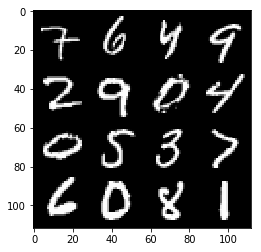

Reconstructed Images


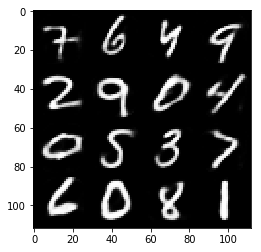

In [5]:
# Initialize the variables (i.e. assign their default value)

SAVED_MODEL_NAME = "autoencoder_final"
LOGDIR = 'log'
        

# Start a new TF session
with tf.Session() as sess:

    if os.path.exists(SAVED_MODEL_NAME + ".meta"):
        print("Restoring trained model from", SAVED_MODEL_NAME + ".meta")
        imported_meta = tf.train.import_meta_graph(SAVED_MODEL_NAME + ".meta")
        imported_meta.restore(sess, tf.train.latest_checkpoint('./'))
        
        train_writer = tf.summary.FileWriter(os.path.join(LOGDIR,'loaded'), sess.graph)    

    else:
        # Start Training
        # Run the initializer
        init = tf.global_variables_initializer()
        sess.run(init)
        
        merged = tf.summary.merge_all()
        train_writer = tf.summary.FileWriter(os.path.join(LOGDIR,'train'), sess.graph)
        print("Logged graph to tensorboard.")
        
        # Training
        for i in range(1, num_steps+1):
            # Prepare Data
            # Get the next batch of MNIST data (only images are needed, not labels)
            batch_x, _ = mnist.train.next_batch(batch_size)

            # Run optimization op (backprop) and cost op (to get loss value)
            summary, _, l = sess.run([merged, optimizer, loss], feed_dict={X: batch_x})
            train_writer.add_summary(summary, i)
            # Display logs per step
            if i % display_step == 0 or i == 1:
                print('Step %i: Minibatch Loss: %f' % (i, l))
                # Create a checkpoint every N iteration
                # saver.save(sess, 'autoencoder_iter', global_step=i)

        saver = tf.train.Saver()
        print("Saving model to disk...")
        saver.save(sess, './' + SAVED_MODEL_NAME) # Has to have a directory specified
        print("Successfully saved model to disk.")
         

    # Testing
    # Encode and decode images from test set and visualize their reconstruction.
    n = 4
    canvas_orig = np.empty((28 * n, 28 * n))
    canvas_recon = np.empty((28 * n, 28 * n))
    for i in range(n):
        # MNIST test set
        batch_x, _ = mnist.test.next_batch(n)
        # Encode and decode the digit image
        # g = sess.run(decoder_op, feed_dict={X: batch_x})
        g = sess.run('decoder/fc_2/Sigmoid:0', feed_dict={'input:0': batch_x}) # this will run even if you just load the model
        
        # Display original images
        for j in range(n):
            # Draw the original digits
            canvas_orig[i * 28:(i + 1) * 28, j * 28:(j + 1) * 28] = \
                batch_x[j].reshape([28, 28])
        # Display reconstructed images
        for j in range(n):
            # Draw the reconstructed digits
            canvas_recon[i * 28:(i + 1) * 28, j * 28:(j + 1) * 28] = \
                g[j].reshape([28, 28])

    print("Original Images")
    plt.figure(figsize=(n, n))
    plt.imshow(canvas_orig, origin="upper", cmap="gray")
    plt.show()

    print("Reconstructed Images")
    plt.figure(figsize=(n, n))
    plt.imshow(canvas_recon, origin="upper", cmap="gray")
    plt.show()
    